In [179]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

# Read Data

In [132]:
# Read file and pass in 
diabetes = pd.read_csv("diabetic_data.csv")

diabetes.head()

medications_full = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

# replace missing with np.nan
diabetes.replace('?', np.nan, inplace = True)
# diabetes.isnull().sum(axis =0)
# missingcols = ['race', 'weight','payer_code','medical_specialty', 'diag_1','diag_2','diag_3']

list(set(medications_full) - set(medications))

['examide', 'citoglipton']

In [133]:
# validation = pd.read_csv('../kailun/data for Richard/validation.csv')
# X_train_all = pd.read_csv('../kailun/data for Richard/X_train_all.csv')
# y_train_all = pd.read_csv('../kailun/data for Richard/y_train_all.csv')


# Make Output Binary

In [134]:
# Binary Classfication of Readmission Attribute
diabetes.readmitted.replace('NO','otherwise', inplace = True)
diabetes.readmitted.replace('>30','otherwise', inplace = True)
diabetes.readmitted.replace('<30','readmitted', inplace = True)
diabetes.readmitted.replace('otherwise',0, inplace = True)
diabetes.readmitted.replace('readmitted',1, inplace = True)


# Dummification

#### Easy Dummification 
- gender (easy: just drop NAs + make 0 or 1)  
- change (easy: 0 or 1) 
- diabetesMed (easy: 0 or 1) 

#### Columns to Dummify
- race (consolidated sparse data in larger buckets 3) 
- age (dummify buckets) 
- admission_type_id (replace numbers with corresponding qualitative value and bucket/dummify) 
- discharge_disposition_id (replace numbers with corresponding qualitative value and bucket/ dummify) 
- admission_source_id (replace numbers with corresponding qualitative value and dummify) 
- medical_specialty (replace numbers with corresponding qualitative value and dummify) 
- diag_1 (bucket / dummify)
- diag_2 (bucket / dummify)
- diag_3 (bucket / dummify)
- max_glu_serum (bucket / dummify)
- A1Cresult (bucket / dummify)
- medications





### Easy Dummification

In [135]:
# DiabetesMed - Dummify
diabetes.diabetesMed.replace('Yes',1, inplace = True)
diabetes.diabetesMed.replace('No',0, inplace = True)

# DiabetesChange - "Dummify"
diabetes.change.replace('Ch',1, inplace = True)
diabetes.change.replace('No',0, inplace = True)
 
# Diabetes.Gender - Dummify + Drop Unknowns
diabetes.gender.replace('Male', 1, inplace = True)
diabetes.gender.replace('Female', 0, inplace = True)

In [136]:
diabetes.loc[(diabetes['diag_1'].str.contains('V')) | (diabetes['diag_1'].str.contains('E')), 'diag_1']= 0
diabetes['diag_1'] = diabetes['diag_1'].replace('?', -1)
diabetes['diag_1'] = diabetes['diag_1'].astype(float)


### Dummification

In [137]:
# Race 
diabetes.race = [x if x in ['Caucasian', 'AfricanAmerican','Asian'] else 'Other' for x in diabetes.race]

# Age
diabetes.age = ['[60, 100)' if x in ['[70-80)','[60-70)','[80-90)','[90-100)'] else 
 '[30, 60)' if x in ['[50-60)','[40-50)','[30-40)'] else 
 '<30' for x in diabetes.age]

# Admissions Source 
emergency = [7]
referral = [1,2,3]
diabetes.admission_source_id = ['Referral' if x in referral else 
 'Emergency' if x in emergency else 
 'Other' for x in diabetes.admission_source_id]

# Discharge 
expired = [11,19,20,21]
home = [1,6,8,13]
diabetes.discharge_disposition_id = ['Home' if x in home else 
           'Expired' if x in expired else 
           'Other' for x in diabetes.discharge_disposition_id]

# Medical Specialty 
cardiology = ['Cardiology',
 'Cardiology-Pediatric']
generalpractice = ['Family/GeneralPractice']
internalmedicine = ['InternalMedicine']
missing = ['?']
surgery = ['Surgeon',
 'Surgery-Cardiovascular',
 'Surgery-Cardiovascular/Thoracic',
 'Surgery-Colon&Rectal',
 'Surgery-General',
 'Surgery-Maxillofacial',
 'Surgery-Neuro',
 'Surgery-Pediatric',
 'Surgery-Plastic',
 'Surgery-PlasticwithinHeadandNeck',
 'Surgery-Thoracic',
 'Surgery-Vascular',
 'SurgicalSpecialty']

diabetes.medical_specialty = ['Cardiology' if x in cardiology else 
 "General Practice" if x in generalpractice else 
 'Internal Medicine' if x in internalmedicine else
 'Surgery' if x in surgery else 
 'Missing' if x in missing else 
 'Other' for x in diabetes.medical_specialty]

# A1C 
diabetes['HA1C']=pd.Series(len(diabetes['A1Cresult']), index=diabetes)
diabetes['HA1C']= 'Not Measured'
diabetes.loc[(diabetes['A1Cresult']=='Norm') | (diabetes['A1Cresult']=='>7'), 'HA1C']= 'Normal'
diabetes.loc[(diabetes['A1Cresult']=='>8') & (diabetes['change']==0), 'HA1C']= 'High, not changed'
diabetes.loc[(diabetes['A1Cresult']=='>8') & (diabetes['change']== 1), 'HA1C']= 'High, changed'

# diagnosis

# Creating an empty column for diag1_collapse
diabetes['diag1_collapse'] = pd.Series(len(diabetes['diag_1']), index=diabetes.index)
# Initiate all the values as 0
diabetes['diag1_collapse'] = 'other'

for index, row in diabetes.iterrows():
    
    if (row['diag_1'] >= 390 and row['diag_1'] <= 359) | (np.floor(row['diag_1']) == 785):
        diabetes.loc[index, 'diag1_collapse'] = 'circulatory'
        
    elif (row['diag_1'] >= 460 and row['diag_1'] <= 519) | (np.floor(row['diag_1']) == 786):
        diabetes.loc[index, 'diag1_collapse'] = 'respiratory'
        
    elif (row['diag_1'] >= 520 and row['diag_1'] <= 579) | (np.floor(row['diag_1']) == 787):
        diabetes.loc[index, 'diag1_collapse'] = 'digestive'
        
    elif (np.floor(row['diag_1']) == 250):
        diabetes.loc[index, 'diag1_collapse'] = 'diabetes'
        
    elif (row['diag_1'] >= 800 and row['diag_1'] <= 999):
        diabetes.loc[index, 'diag1_collapse'] = 'injury'
        
    elif (row['diag_1'] >= 710 and row['diag_1'] <= 739):
        diabetes.loc[index, 'diag1_collapse'] = 'muscul'
        
    elif (row['diag_1'] >= 580 and row['diag_1'] <= 629) | (np.floor(row['diag_1']) == 788):
        diabetes.loc[index, 'diag1_collapse'] = 'genit'
        
    elif (row['diag_1'] >= 140 and row['diag_1'] <= 239):
        diabetes.loc[index, 'diag1_collapse'] = 'neoplasms'

In [139]:
# Race
race_dummy = pd.get_dummies(diabetes.race, prefix = "race", drop_first=True)

# Age
age_dummy = pd.get_dummies(diabetes.age, prefix = 'age', drop_first = True)

# Admissions Source
admissions_dummy = pd.get_dummies(diabetes.admission_source_id, prefix = 'Admissions', drop_first=True)

# Discharge 
discharge_dummy = pd.get_dummies(diabetes.discharge_disposition_id, prefix = 'discharge', drop_first=True)

# Medical Specialty
specialty_dummy = pd.get_dummies(diabetes.medical_specialty, prefix = 'specialty', drop_first = True)

# A1C
a1c_dummy = pd.get_dummies(diabetes.HA1C, prefix = 'a1c')
a1c_dummy.drop(columns = ['a1c_Not Measured'], inplace = True)

# Medications 
med_eda = diabetes[medications]
med_eda
med_dummy = pd.get_dummies(med_eda, columns = medications, drop_first = True)
diabetes.drop(columns = medications_full, inplace = True )

# Diagnosis 
diag_dummy = pd.get_dummies(diabetes.diag1_collapse, prefix = 'diag', drop_first=True)

In [143]:
# Drop Dummified Columns
diabetes.drop(columns = ['race','age','weight',
               'admission_type_id','discharge_disposition_id',
               'admission_source_id','payer_code','medical_specialty', 'A1Cresult','HA1C', 'diag1_collapse'], inplace = True)
readmitted = diabetes.pop('readmitted')


diabetes_final = diabetes.copy()
diabetes_final = pd.concat([diabetes_final, race_dummy], axis = 1)
diabetes_final = pd.concat([diabetes_final, age_dummy], axis = 1)
diabetes_final = pd.concat([diabetes_final, admissions_dummy], axis = 1)
diabetes_final = pd.concat([diabetes_final, discharge_dummy], axis = 1)
diabetes_final = pd.concat([diabetes_final, specialty_dummy], axis = 1)
diabetes_final = pd.concat([diabetes_final, a1c_dummy], axis = 1)
diabetes_final = pd.concat([diabetes_final, med_dummy], axis = 1)
diabetes_final = pd.concat([diabetes_final, diag_dummy], axis = 1)
diabetes_final['readmitted'] = readmitted
diabetes_final = diabetes_final.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
diabetes_final.drop(columns = ['encounter_id', 'patient_nbr','diag_1','diag_2','diag_3','max_glu_serum'], inplace = True)
diabetes_final = diabetes_final[diabetes_final.gender != 'Unknown/Invalid']


# diabetes_final = pd.concat([diabetes_final, diag_dummy], axis = 1)
diabetes_final.shape

# Removing Meds to See if 
# meddummylist = list(med_dummy.columns)
# diabetes_final.drop(columns = meddummylist, inplace = True)



(71515, 84)

# Model Training

In [195]:
X = diabetes_final.iloc[:,:-1]
y = diabetes_final.readmitted


# Train, validation, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
param_grid = {'penalty':['l1', 'l2', 'elasticnet'],'C':[1, 10, 100, 1000], 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

### Logistic Regression - No Resampling

In [182]:
diabetes_model = GridSearchCV(LogisticRegression(), param_grid, n_jobs = -1, cv = 5, verbose = 1)
diabetes_model.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [186]:
predictions = diabetes_model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13035
           1       0.36      0.00      0.01      1268

    accuracy                           0.91     14303
   macro avg       0.64      0.50      0.48     14303
weighted avg       0.86      0.91      0.87     14303

[[13028     7]
 [ 1264     4]]
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


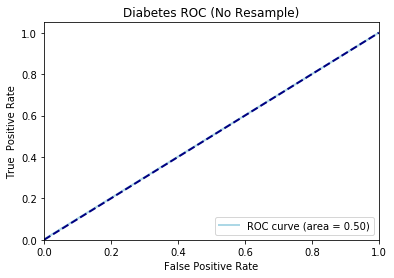

In [185]:
from sklearn.metrics import roc_curve, auc 
fpr, tpr, treshold = roc_curve(y_test, diabetes_model.predict(X_test))
roc_auc  = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lightblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True  Positive Rate')
plt.title('Diabetes ROC (No Resample)')
plt.legend(loc='lower right')
plt.show()

### Logistic Regression - SMOTE 

In [187]:
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train) 
X_val_smote, y_val_smote = sm.fit_sample(X_val, y_val)

In [188]:
diabetes_model_smote = GridSearchCV(LogisticRegression(), param_grid, n_jobs = -1, cv = 5, verbose = 1)
diabetes_model_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 34.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [189]:
predictions_smote = diabetes_model_smote.predict(X_test)

print(classification_report(y_test, predictions_smote))
confusion_matrix(y_test, predictions_smote)


              precision    recall  f1-score   support

           0       0.91      0.98      0.94     13035
           1       0.10      0.03      0.04      1268

    accuracy                           0.89     14303
   macro avg       0.51      0.50      0.49     14303
weighted avg       0.84      0.89      0.86     14303



array([[12754,   281],
       [ 1236,    32]])

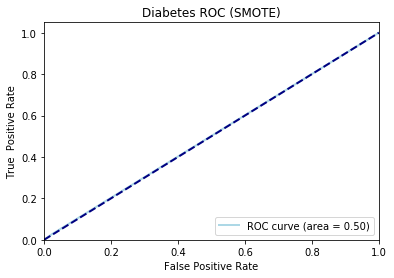

In [191]:
fpr, tpr, treshold = roc_curve(y_test, diabetes_model_smote.predict(X_test))
roc_auc  = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lightblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True  Positive Rate')
plt.title('Diabetes ROC (SMOTE)')
plt.legend(loc='lower right')
plt.show()

### Logistic Regression - Random Under Sampler

In [196]:
rus = RandomUnderSampler(sampling_strategy= 1.0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_val_rus, y_val_rus = rus.fit_resample(X_val,y_val)

# from sklearn.utils import resample
# resample( majority_df, 5000)
# resample( min_df, 5000 )

In [197]:
diabetes_model_rus = GridSearchCV(LogisticRegression(), param_grid, n_jobs = -1, cv = 5, verbose = 1)


In [198]:
diabetes_model_rus.fit(X_train_rus, y_train_rus)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:  1.8min remaining:    5.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [199]:
print(classification_report(y_test, diabetes_model_rus.predict(X_test)))
print(confusion_matrix(y_test, diabetes_model_rus.predict(X_test)))
 

              precision    recall  f1-score   support

           0       0.93      0.64      0.76     13005
           1       0.13      0.54      0.21      1298

    accuracy                           0.63     14303
   macro avg       0.53      0.59      0.49     14303
weighted avg       0.86      0.63      0.71     14303

[[8363 4642]
 [ 591  707]]


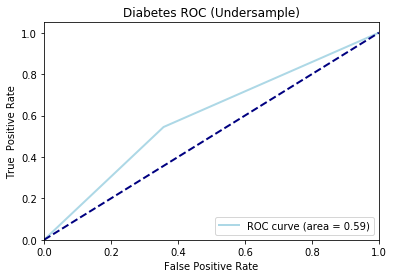

In [200]:
fpr, tpr, treshold = roc_curve(y_test, diabetes_model_rus.predict(X_test))
roc_auc  = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='lightblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True  Positive Rate')
plt.title('Diabetes ROC (Undersample)')
plt.legend(loc='lower right')
plt.show()

## Logistic Regression Presentation 

### Minimal Viable Product
+ Use the encounters from Kailun's splits (Same Dataset) 
+ Sync up on features (conversation / consensus between Charlie and Rich )
+ Fill out Jae's shell for logistic and decile for this model 
+ Present

### Once complete 
+ PCA 